In [ ]:
%matplotlib inline

[Pivoted Document Length Normalization (Singhal, Buckley and Mitra)](http://singhal.info/pivoted-dln.pdf)
=====================================

* PDLN counters the problem of short document bias when working with TfIdf -- thereby
increasing classification accuracy.


* Normalized tfidf weights for each term often favor the weights of terms in documents with shorter length. The *pivoted document length normalization* scheme mitigates this problem by  making tfidf independent of document length.

* This is done by *tilting* the normalization curve along the pivot point defined by user with some slope:

    ``pivoted_norm = (1 - slope) * pivot + slope * old_norm``

* This approach can increase model accuracy when a corpus's document lengths have wide variance.

* We will train a logistic regression to distinguish between text from two different newsgroups.
* Show that PDLN yields a better model (higher classification accuracy).

In [1]:
# Download our dataset
import gensim.downloader as api
nws = api.load("20-newsgroups")

# Pick texts from relevant newsgroups, split into training and test set.
cat1, cat2 = ('sci.electronics', 'sci.space')

# X_* contain the actual texts as strings.
# Y_* contain labels, 0 for cat1 (sci.electronics) and 1 for cat2 (sci.space)

X_train, X_test, y_train, y_test = [],[],[],[]

for i in nws:
    if i["set"] == "train" and i["topic"] == cat1:
        X_train.append(i["data"])
        y_train.append(0)

    elif i["set"] == "train" and i["topic"] == cat2:
        X_train.append(i["data"])
        y_train.append(1)
        
    elif i["set"] == "test" and i["topic"] == cat1:
        X_test.append(i["data"])
        y_test.append(0)
        
    elif i["set"] == "test" and i["topic"] == cat2:
        X_test.append(i["data"])
        y_test.append(1)

unable to import 'smart_open.gcs', disabling that module


[==================================================] 100.1% 13.8/13.8MB downloaded


/home/bjpcjp/.local/lib/python3.6/site-packages/smart_open-1.11.1-py3.6.egg/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [2]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.corpora import Dictionary

id2word      = Dictionary([preprocess_string(doc) for doc in X_train])
train_corpus = [id2word.doc2bow(preprocess_string(doc)) for doc in X_train]
test_corpus  = [id2word.doc2bow(preprocess_string(doc)) for doc in X_test]

print(len(X_train), len(X_test))

# We perform our analysis on top k documents which is almost top 10% most scored documents
k = len(X_test) // 10

1184 787


* define evaluation function




In [3]:
from gensim.sklearn_api.tfidf import TfIdfTransformer
from sklearn.linear_model     import LogisticRegression
from gensim.matutils          import corpus2csc

# returns model accuracy + indivitual document prob values
# uses TfIdfTransformer (gensim) and sklearn's LogisticRegression (sklearn)

def get_tfidf_scores(kwargs):
    tfidf_transformer = TfIdfTransformer(**kwargs).fit(train_corpus)

    X_train_tfidf  = corpus2csc(tfidf_transformer.transform(train_corpus), 
                                num_terms=len(id2word)).T
    X_test_tfidf   = corpus2csc(tfidf_transformer.transform(test_corpus), 
                                num_terms=len(id2word)).T
    clf            = LogisticRegression().fit(X_train_tfidf, 
                                              y_train)
    model_accuracy = clf.score(X_test_tfidf, 
                               y_test)
    doc_scores     = clf.decision_function(X_test_tfidf)

    return model_accuracy, doc_scores

Get TFIDF scores for corpus WITHOUT PDLN:
-----------------------------------------



In [4]:
params = {}
model_accuracy, doc_scores = get_tfidf_scores(params)
print(model_accuracy)

0.9682337992376112


### Examine bias towards shorter documents
- sort documents by scores, return scores and lengths


In [6]:
import numpy as np

def sort_length_by_score(doc_scores, X_test):

    doc_scores = sorted(enumerate(doc_scores), key=lambda x: x[1])
    doc_leng   = np.empty(len(doc_scores))
    ds         = np.empty(len(doc_scores))

    for i, _ in enumerate(doc_scores):
        doc_leng[i] = len(X_test[_[0]])
        ds[i]       = _[1]

    return ds, doc_leng

print(
   "Normal cosine normalisation favors short documents - top {} "
   "docs mean doc length of {:.3f} compared to the corpus mean doc length of {:.3f}"
   .format(
       k, 
       sort_length_by_score(doc_scores, X_test)[1][:k].mean(), 
       sort_length_by_score(doc_scores, X_test)[1].mean()
   )
)

Normal cosine normalisation favors short documents - top 78 docs mean doc length of 1668.179 compared to the corpus mean doc length of 1577.799


Get TFIDF scores for corpus with PDLN
----------------------------------------------------------------------

* Using various values of alpha (slope).



In [7]:
best_model_accuracy = 0
optimum_slope = 0
for slope in np.arange(0, 1.1, 0.1):
    params = {"pivot": 10, "slope": slope}

    model_accuracy, doc_scores = get_tfidf_scores(params)

    if model_accuracy       > best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope       = slope

    print("Score for slope {} is {}".format(slope, model_accuracy))

print("We get best score of {} at slope {}".format(best_model_accuracy, optimum_slope))

Score for slope 0.0 is 0.9707750952986023
Score for slope 0.1 is 0.9720457433290979
Score for slope 0.2 is 0.9758576874205845
Score for slope 0.30000000000000004 is 0.9783989834815756
Score for slope 0.4 is 0.97712833545108
Score for slope 0.5 is 0.9758576874205845
Score for slope 0.6000000000000001 is 0.974587039390089
Score for slope 0.7000000000000001 is 0.9720457433290979
Score for slope 0.8 is 0.9733163913595934
Score for slope 0.9 is 0.9707750952986023
Score for slope 1.0 is 0.9682337992376112
We get best score of 0.9783989834815756 at slope 0.30000000000000004


* Evaluate the model with optimum slope




In [9]:
params                     = {"pivot": 10, "slope": optimum_slope}
model_accuracy, doc_scores = get_tfidf_scores(params)
print(model_accuracy)

print(
   "Pivoted normalisation: top {} docs mean length = {:.3f} "
   "; corpus mean doc length = {:.3f}"
   .format(
       k, sort_length_by_score(doc_scores, X_test)[1][:k].mean(), 
       sort_length_by_score(doc_scores, X_test)[1].mean()
   )
)

0.9783989834815756
Pivoted normalisation: top 78 docs mean length = 2077.346 ; corpus mean doc length = 1577.799


Visualizing the pivoted normalization
-------------------------------------

* Since cosine normalization favors retrieval of short documents from the plot
we can see that when slope was 1 (when pivoted normalisation was not applied)
short documents with length of around 500 had very good score hence the bias
for short documents can be seen. 
* Varying slope from 1 to 0 intoduces a new bias for long documents to counter the bias caused by cosine normalisation. Therefore at a certain point we got an optimum value of slope which is 0.5 where the overall accuracy of the model is increased.




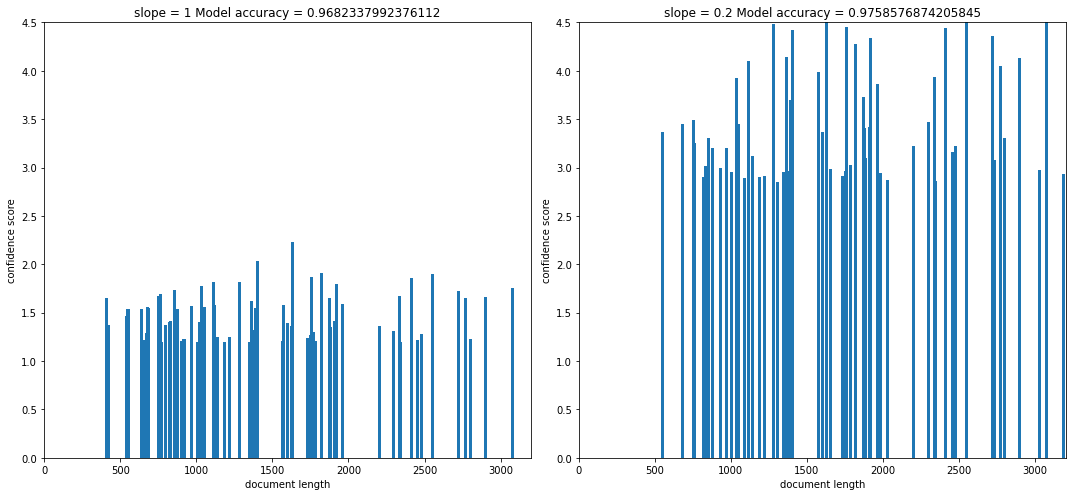

In [11]:
import matplotlib.pyplot as py

best_model_accuracy = 0
optimum_slope = 0

w = 2
h = 2
f, axarr = py.subplots(h, w, figsize=(15, 7))

it = 0
for slope in [1, 0.2]:
    params = {"pivot": 10, "slope": slope}

    model_accuracy, doc_scores = get_tfidf_scores(params)

    if model_accuracy > best_model_accuracy:
        best_model_accuracy = model_accuracy
        optimum_slope = slope

    doc_scores, doc_leng = sort_length_by_score(doc_scores, X_test)

    y = abs(doc_scores[:k, np.newaxis])
    x = doc_leng[:k, np.newaxis]

    py.subplot(1, 2, it+1).bar(x, y, width=20, linewidth=0)
    py.title("slope = " + str(slope) + " Model accuracy = " + str(model_accuracy))
    py.ylim([0, 4.5])
    py.xlim([0, 3200])
    py.xlabel("document length")
    py.ylabel("confidence score")
    
    it += 1

py.tight_layout()
py.show()

* The above histogram visualizes the effect of ``slope``. For top k documents we have document length on the x axis and their respective scores of belonging to a specific class on y axis.  
* Decreasing slope shifts the bin densities from low (~250-500) to over ~500 document lengths. This suggests the positive bias seen at ``slope=1`` (when tfidf was used) for short documents is now reduced. We get the optimum slope or the max model accuracy when slope is 0.2.

Conclusion
==========
* PDN significantly improved the classification accuracy.